In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re
# import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import logspace
import lightgbm as lgb
import xgboost as xgb
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading airbnb data of 8 cities
montreal = pd.read_csv('Dataset/Airbnb/Montreal.csv')
newbrunswick = pd.read_csv('Dataset/Airbnb/NewBrunswick.csv')
ottawa = pd.read_csv('Dataset/Airbnb/Ottawa.csv')
quebeccity = pd.read_csv('Dataset/Airbnb/QuebecCity.csv')
toronto = pd.read_csv('Dataset/Airbnb/Toronto.csv')
vancouver = pd.read_csv('Dataset/Airbnb/Vancouver.csv')
victoria = pd.read_csv('Dataset/Airbnb/Victoria.csv')
winnipeg = pd.read_csv('Dataset/Airbnb/Winnipeg.csv')


# Adding a City column to each dataframes
montreal['city'] = 'Montreal'
newbrunswick['city'] = 'New Brunswick'
ottawa['city'] = 'Ottawa'
quebeccity['city'] = 'Quebec City'
toronto['city'] = 'Toronto'
vancouver['city'] = 'Vancouver'
victoria['city'] = 'Victoria'
winnipeg['city'] = 'Winnipeg'

# Merging data from different cities to a single dataframe
airbnb_df = pd.concat([montreal, newbrunswick, ottawa, quebeccity, toronto, vancouver, victoria, winnipeg], ignore_index=True)

In [3]:
# Loading the review sentiment scores
reviews_df = pd.read_csv('Dataset/Sentiment/listing_sentiment_scores.csv')

airbnb_df = pd.merge(airbnb_df, reviews_df, left_on='id', right_on='listing_id', how='left')

Initial Feature Elimination

In [4]:
feature_elimination_list = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 'host_thumbnail_url', 'calendar_updated', 'calendar_last_scraped', 'host_name', 'listing_id', 'host_id', 'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_location', 'neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'review_scores_accuracy', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_about', 'neighborhood_overview']

airbnb_df = airbnb_df.drop(feature_elimination_list, axis=1)

Renaming columns

In [5]:
# Mapping new column names
column_mappings = {
    'name': 'title',
    'first_review': 'first_review_date',
    'last_review': 'last_review_date',
    'review_scores_value': 'review_scores_value_for_money',
    'calculated_host_listings_count': 'host_listings_count',
    'neighbourhood_cleansed': 'neighbourhood',
    'sentiment_score': 'review_sentiment_score'
}

# Renaming columns
airbnb_df.rename(columns=column_mappings, inplace=True)

Price to integer

In [6]:
# Removing "$" from price and converting to float
airbnb_df['price'] = airbnb_df['price'].str.replace('[$,]', '', regex=True).astype(float)

Train-test split

In [7]:
data_train, data_test = train_test_split(airbnb_df, test_size=0.2, random_state=42)

Preprocessing

In [8]:
# Converting values in price column to its natural logarithm
data_train['price'] = np.log(data_train['price'])

In [9]:
# Fill null value with unlicensed
data_train['license'].fillna('Unlicensed', inplace=True)

In [10]:
# Drop rows with empty price
data_train = data_train.dropna(subset=['price'])

In [11]:
# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
columns_to_fill = [
    'review_scores_value_for_money',
    'review_scores_location',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_cleanliness',
    'review_scores_rating'
]

for column in columns_to_fill:
    data_train.loc[data_train['number_of_reviews'] == 0, column] = 0

In [12]:
data_train['review_sentiment_score'].fillna(0, inplace=True)

In [13]:
# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Fill null values with today's date where 'number_of_reviews' equals 0
data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'] = data_train.loc[data_train['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

In [14]:
data_train['host_is_superhost'] = data_train['host_is_superhost'].fillna('f')
data_train['has_availability'] = data_train['has_availability'].fillna('f')

In [15]:
data_train['host_response_time'] = data_train['host_response_time'].fillna(data_train['host_response_time'].mode()[0])

In [16]:
# Remove % sign and convert to numeric for the following columns
data_train['host_response_rate'] = pd.to_numeric(data_train['host_response_rate'].str.replace('%', ''))
data_train['host_acceptance_rate'] = pd.to_numeric(data_train['host_acceptance_rate'].str.replace('%', ''))

# Creating a list of required columns
numeric_columns = [
    'host_response_rate',
    'host_acceptance_rate',
    'bedrooms', 'beds', 
    'review_scores_value_for_money', 
    'review_scores_location', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_cleanliness', 
    'bathrooms'
]

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_train[column].median()
    data_train[column].fillna(median_value, inplace=True)

Feature Engineering

In [17]:
current_date = datetime.now()

# Converting date columns
data_train['host_since'] = pd.to_datetime(data_train['host_since'])
data_train['first_review_date'] = pd.to_datetime(data_train['first_review_date'])
data_train['last_review_date'] = pd.to_datetime(data_train['last_review_date'])

# Calculating values and storing in a new column
data_train['host_since_days'] = (current_date - data_train['host_since']).dt.days
data_train['first_review_days'] = (current_date - data_train['first_review_date']).dt.days
data_train['last_review_days'] = (current_date - data_train['last_review_date']).dt.days

# Dropping date columns
data_train.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [18]:
# Define downtown coordinates for each city
downtown_coords = {
    'Montreal': (45.5017, -73.5673),
    'New Brunswick': (45.9636, -66.6372),  # Fredericton
    'Ottawa': (45.4215, -75.6972),
    'Quebec City': (46.8139, -71.2080),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207),
    'Victoria': (48.4284, -123.3656),
    'Winnipeg': (49.8951, -97.1384)
}

In [19]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [20]:
# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_train['city'] == city
    data_train.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_train.loc[mask, 'latitude'].values, 
        data_train.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [21]:
# Load attraction data
attractions_df = pd.read_csv('Dataset/Locations/canadian_tourist_attractions.csv')
attractions_df['city'] = attractions_df['city'].str.title().str.replace('_', ' ')
attractions_df.head()

,city,name,latitude,longitude,type
0,Montreal,Musée des Beaux-Arts de Montréal,45.498697,-73.579385,museum
1,Montreal,Belvédère Léo-Ayotte,45.523223,-73.568744,viewpoint
2,Montreal,Musée des ondes Emile Berliner,45.477550,-73.592403,museum
3,Montreal,Orbite,45.523473,-73.536689,attraction
4,Montreal,Spirale,45.525468,-73.534699,attraction


In [22]:
# Count attractions within 10km using broadcasting
def count_attractions_within_radius(airbnb_lat, airbnb_lon, attractions, radius_km=10):
    distances = haversine_distance(airbnb_lat, airbnb_lon, attractions['latitude'].values, attractions['longitude'].values)
    return np.sum(distances <= radius_km)

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_train['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_train[data_train['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_train[data_train['city'] == city]))

data_train['nearby_attractions'] = attraction_counts

Data Encoding

In [23]:
for boolean_column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_train[boolean_column] = data_train[boolean_column].map(lambda s: False if s == "f" else True)

def picture(row):
    if (row['picture_url']==''):
        return False
    else:
        return True
data_train['has_picture']=data_train.apply(lambda row: picture(row), axis=1)

def host_picture(row):
    if (row['host_picture_url']==''):
        return False
    else:
        return True
data_train['has_host_picture']=data_train.apply(lambda row: picture(row), axis=1)

# Dropping picture url columns
data_train.drop(columns=['picture_url', 'host_picture_url'], inplace=True)

In [24]:
# Changing data
data_train['license'] = data_train['license'].map(lambda s: False if s == "Unlicensed" else True)

In [25]:
# Define the order of categories
categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Initialize OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=[categories])

# Fit and transform the 'host_response_time' column
data_train['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_train[['host_response_time']])

# Dropping the categorical column
data_train.drop(columns=['host_response_time'], inplace=True)

In [26]:
data_train = pd.get_dummies(data_train, columns=['property_type'], prefix='property')
data_train = pd.get_dummies(data_train, columns=['city'], prefix='city')
data_train = pd.get_dummies(data_train, columns=['room_type'], prefix='room_type')

In [27]:
# Function to safely evaluate strings
def safe_eval(x):
    if isinstance(x, str):
        return eval(x)
    return x

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_train['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_train[column_name] = data_train['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('host_verifications', axis=1, inplace=True)

Feature Extraction

In [28]:
# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_train['amenities'].apply(safe_eval) for item in sublist if item)

In [29]:
#Define keywords and corresponding regex patterns
keywords_patterns = {
    'tv': r'\b(TV|HDTV|Netflix|Roku|Amazon|chromecast|hulu|disney+)\b',
    'pool': r'\b(Pool|Swimming pool)\b',
    'oven': r'\b(Oven|microwave)\b',
    'stove': r'\b(Stove|stove)\b',
    'wifi': r'\b(Wifi)\b',
    'toiletries': r'\b(Toiletries|Shampoo|Brush|Conditioner|soap|wash|shower gel)\b',
    'parking': r'\b(parking|carport)\b',
    'sound_system': r'\b(SoundSystem|Sound System|speakers|speaker|piano|record player)\b',
    'coffee_maker': r'\b(coffee|coffee-maker|coffeemaker|espresso)\b',
    'grill': r'\b(Grill|BBQ)\b',
    'workspace': r'\b(Workspace|Workspaces)\b',
    'closet': r'\b(Closet|storage|wardrobe|dresser)\b',
    'exercise_equipment': r'\b(Exercise|yoga|elliptical|bike|bikes|gym)\b',
    'refrigerator': r'\b(Refrigerator|refrigerator|freezer|ice machine|fridge)\b',
    'housekeeping': r'\b(Housekeeping|Housekeeping)\b',
    'backyard': r'\b(backyard|patio|balcony)\b',
    'safety': r'\b(Safety|Safety|lock|pin|alarm)\b',
    'spa': r'\b(Sauna|sauna|jacuzzi|tub|spa|steam room|sun loungers)\b',
    'view': r'\b(lake|skyline|view|courtyard|resort|waterfront)\b',
    'laundry': r'\b(Laundry|laundry|laundromat|drying|dryer)\b',
    'garbage': r'\b(Garbage|garbage)\b',
    'games': r'\b(Game console|gaming console|gaming consoles|ps2|ps3|ps4|ps5|xbox|nintendo|games|ping pong)\b',
    'first_aid': r'\b(first aid)\b',
    'smoke_alarm': r'\b(smoke alarm|fire extinguisher|alarm)\b',
    'private_entrance': r'\b(private entrance)\b',
    'AC': r'\b(heating|conditioning|AC)\b',
    'bedding': r'\b(pillows|pillow|blanket|blankets|bed linens)\b',
    'washer': r'\b(washer)\b',
    'baby_ameneties': r'\b(crib|baby|high chair|changing table|playroom|playground)\b',
    'utensils': r'\b(utensils|cooking|dishes|silverware|glasses)\b',
    'kitchen': r'\b(kitchen|dining|rice maker|blender|kitchenette)\b',
    'bathtub': r'\b(bathtub)\b',
    'iron': r'\b(iron|ironing board)\b',
    'self_checking': r'\b(Self check-in|check-in|self_checking|self checkin|self checking)\b',
    'hangers': r'\b(hangers)\b',
    'hair_dryer': r'\b(hair dryer)\b',
    'security_camera': r'\b(security|camera|cameras)\b',
    'lock_on_door': r'\b(lock|keypad)\b',
    'toaster': r'\b(toaster|bread maker)\b',
    'pets_allowed' : r'\b(pets allowed)\b',
    'hot_water': r'\b(hot water)\b',
    'bookshelf': r'\b(bookshelf|books|reading)\b',
    'cleaning products': r'\b(cleaning products)\b',
    'fire pit': r'\b(fire pit|fire place|firepit|fireplace)\b',
    'garage': r'\b(garage)\b',
    'elevator': r'\b(elevator)\b',
    'beach': r'\b(beach)\b',
    'host_there': r'\b(host greets you|property manager)\b',
    'bar': r'\b(bar)\b',
    'sports': r'\b(kayak|golf|ski|ski-in/ski-out|lasertag|laser tag|batting cage|wall climbing|climbing wall|bowling|hockey rink|skate ramp)\b',
    'hammock': r'\b(hammock)\b',
    'ev_charger': r'\b(ev charger)\b',
    'movie_theater': r'\b(movie theater|media room|theme room)\b',
}

# Function to rename items based on regex patterns
def rename_item(amenity, patterns):
    for key, pattern in patterns.items():
        if re.search(pattern, amenity, flags=re.IGNORECASE):
            return key
    return amenity

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Print the total number of unique items
print("Total number of unique updated amenities:", len(unique_updated_amenities))
print(unique_updated_amenities)

Total number of unique updated amenities: 81
['cleaning products', 'AC', 'beach', 'hammock', 'sports', 'Bidet', 'self_checking', 'Babysitter recommendations', 'hot_water', 'lock_on_door', 'Outlet covers', 'coffee_maker', 'iron', 'Safe', 'garage', 'Window guards', 'view', 'sound_system', 'backyard', 'laundry', 'pool', 'housekeeping', 'Ceiling fan', 'Long term stays allowed', 'refrigerator', 'Trash compactor', 'utensils', 'Table corner guards', 'bar', 'stove', 'Outdoor furniture', 'baby_ameneties', 'Boat slip', 'workspace', 'Single level home', 'Lockbox', 'security_camera', 'parking', 'smoke_alarm', 'elevator', 'Room-darkening shades', 'Private living room', 'washer', 'Dishwasher', 'Breakfast', 'toaster', 'closet', 'Portable heater', 'exercise_equipment', 'Ethernet connection', 'movie_theater', 'Outdoor shower', 'hangers', 'pets_allowed', 'Luggage dropoff allowed', 'wifi', 'safety', 'Portable fans', 'toiletries', 'Smoking allowed', 'Children’s dinnerware', 'private_entrance', 'Building s

In [30]:
# Apply the function to rename items in the 'amenities' column
data_train['amenities'] = data_train['amenities'].apply(lambda x: rename_item(x, keywords_patterns) if isinstance(x, list) else "")

In [31]:
# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_train[column_name] = data_train['amenities'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('amenities', axis=1, inplace=True)

In [32]:
# Need to download once for sentiment analysis
# nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# creating new columns using polarity scores function
data_train['title_scores'] = data_train['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_train['title_compound']=data_train['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_train['title_negativity']=data_train['title_scores'].apply(lambda score_dict:score_dict['neg'])
data_train['title_neutrality']=data_train['title_scores'].apply(lambda score_dict:score_dict['neu'])
data_train['title_positivity']=data_train['title_scores'].apply(lambda score_dict:score_dict['pos'])
data_train.drop(['title', 'title_scores'], axis=1, inplace=True)


# creating new columns using polarity scores function
data_train['description_scores']=data_train['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_train['description_compound']=data_train['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_train['description_negativity']=data_train['description_scores'].apply(lambda score_dict:score_dict['neg'])
data_train['description_neutrality']=data_train['description_scores'].apply(lambda score_dict:score_dict['neu'])
data_train['description_positivity']=data_train['description_scores'].apply(lambda score_dict:score_dict['pos'])
data_train.drop(['description', 'description_scores'], axis=1, inplace=True)

Feature Selection

In [33]:
train_features = data_train.drop(['id', 'neighbourhood'], axis=1)

Replicating changes to test data

In [34]:
# Converting values in price column to its natural logarithm
data_test['price'] = np.log(data_test['price'])

In [35]:
# Fill null value with unlicensed
data_test['license'].fillna('Unlicensed', inplace=True)

# Drop rows with empty price
data_test = data_test.dropna(subset=['price'])

# Fill null values with 0 for specified columns where 'number_of_reviews' equals 0
for column in columns_to_fill:
    data_test.loc[data_test['number_of_reviews'] == 0, column] = 0

# Filling null values in review_sentiment_score to 0    
data_test['review_sentiment_score'].fillna(0, inplace=True)

# Fill null values with today's date where 'number_of_reviews' equals 0
data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'first_review_date'].fillna(today_date)
data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'] = data_test.loc[data_test['number_of_reviews'] == 0, 'last_review_date'].fillna(today_date)

# Fill null in host realted columns
data_test['host_is_superhost'] = data_test['host_is_superhost'].fillna('f')
data_test['has_availability'] = data_test['has_availability'].fillna('f')
data_test['host_response_time'] = data_test['host_response_time'].fillna(data_test['host_response_time'].mode()[0])

# Remove % sign and convert to numeric for the following columns
data_test['host_response_rate'] = pd.to_numeric(data_test['host_response_rate'].str.replace('%', ''))
data_test['host_acceptance_rate'] = pd.to_numeric(data_test['host_acceptance_rate'].str.replace('%', ''))

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_test[column].median()
    data_test[column].fillna(median_value, inplace=True)

In [36]:
# Adding days since columns
# Converting date columns
data_test['host_since'] = pd.to_datetime(data_test['host_since'])
data_test['first_review_date'] = pd.to_datetime(data_test['first_review_date'])
data_test['last_review_date'] = pd.to_datetime(data_test['last_review_date'])

# Calculating values and storing in a new column
data_test['host_since_days'] = (current_date - data_test['host_since']).dt.days
data_test['first_review_days'] = (current_date - data_test['first_review_date']).dt.days
data_test['last_review_days'] = (current_date - data_test['last_review_date']).dt.days

# Dropping date columns
data_test.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [37]:
# Distance to downtown

# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_test['city'] == city
    data_test.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_test.loc[mask, 'latitude'].values, 
        data_test.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [38]:
# Number of attractions

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_test['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_test[data_test['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_test[data_test['city'] == city]))

data_test['nearby_attractions'] = attraction_counts

In [39]:
# Converting boolean columns and picture url columns to 0s and 1s
for boolean_column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_test[boolean_column] = data_test[boolean_column].map(lambda s: False if s == "f" else True)

data_test['has_picture']=data_test.apply(lambda row: picture(row), axis=1)
data_test['has_host_picture']=data_test.apply(lambda row: picture(row), axis=1)

# Dropping picture url columns
data_test.drop(columns=['picture_url', 'host_picture_url'], inplace=True)

In [40]:
# Changing data in license column to licensed and unlicensed and converting to boolean
data_test['license'] = data_test['license'].map(lambda s: False if s == "Unlicensed" else True)

# Ordinal Encoding host_response_time since there is a clear order
data_test['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_test[['host_response_time']])
data_test.drop(columns=['host_response_time'], inplace=True)

# One hot encoding property_type, city, and room_type
data_test = pd.get_dummies(data_test, columns=['property_type'], prefix='property')
data_test = pd.get_dummies(data_test, columns=['city'], prefix='city')
data_test = pd.get_dummies(data_test, columns=['room_type'], prefix='room_type')

In [41]:
# One hot encoding verifications

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_test['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_test[column_name] = data_test['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('host_verifications', axis=1, inplace=True)

In [42]:
# Amenities

# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_test['amenities'].apply(safe_eval) for item in sublist if item)

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Apply the function to rename items in the 'amenities' column
data_test['amenities'] = data_test['amenities'].apply(lambda x: rename_item(x, keywords_patterns) if isinstance(x, list) else "")

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_test[column_name] = data_test['amenities'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('amenities', axis=1, inplace=True)

In [43]:
# Sentiment Scores

# creating new columns using polarity scores function
data_test['title_scores'] = data_test['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_test['title_compound']=data_test['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_test['title_negativity']=data_test['title_scores'].apply(lambda score_dict:score_dict['neg'])
data_test['title_neutrality']=data_test['title_scores'].apply(lambda score_dict:score_dict['neu'])
data_test['title_positivity']=data_test['title_scores'].apply(lambda score_dict:score_dict['pos'])
data_test.drop(['title', 'title_scores'], axis=1, inplace=True)

# creating new columns using polarity scores function
data_test['description_scores']=data_test['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_test['description_compound']=data_test['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_test['description_negativity']=data_test['description_scores'].apply(lambda score_dict:score_dict['neg'])
data_test['description_neutrality']=data_test['description_scores'].apply(lambda score_dict:score_dict['neu'])
data_test['description_positivity']=data_test['description_scores'].apply(lambda score_dict:score_dict['pos'])
data_test.drop(['description', 'description_scores'], axis=1, inplace=True)

In [44]:
test_features = data_test.drop(['id', 'neighbourhood'], axis=1)

Data Preparation

In [45]:
# Assigning appropriate names to training and resting data
X_train = train_features.drop(['price'], axis=1)
y_train = train_features['price']
X_test = test_features.drop(['price'], axis=1)
y_test = test_features['price']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33288, 231), (8284, 211), (33288,), (8284,))

In [46]:
# Aligning column discrepancy due to separating amenities. Important step.
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33288, 206), (8284, 206), (33288,), (8284,))

In [47]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Modeling

In [48]:
# Build the model
final_model_lgbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=3000, num_leaves=200, verbose=0, max_depth=-1, random_state=42)

In [49]:
final_model_lgbm.fit(X_train_scaled, y_train)
y_pred_gbm = final_model_lgbm.predict(X_test_scaled)
ytrai_gbm = final_model_lgbm.predict(X_train_scaled)

# Evaluate Light GBM
lgbmr2 = r2_score(y_test, y_pred_gbm)
lgbmmse = mean_squared_error(y_test, y_pred_gbm)

# Evaluate Light GBM
lgbmr2t = r2_score(y_train, ytrai_gbm)
lgbmmset = mean_squared_error(y_train, ytrai_gbm)

# Calculating and printing the evaluation metrices values
print(f'Light GBM Fitting:')
print(f'R2 Score: {lgbmr2}')
print(f'MSE: {lgbmmse}')

print (lgbmr2t)
print (lgbmmset)

Light GBM Fitting:
R2 Score: 0.7580863089986347
MSE: 0.11987271183983975
0.9780210518104636
0.010893673920724135


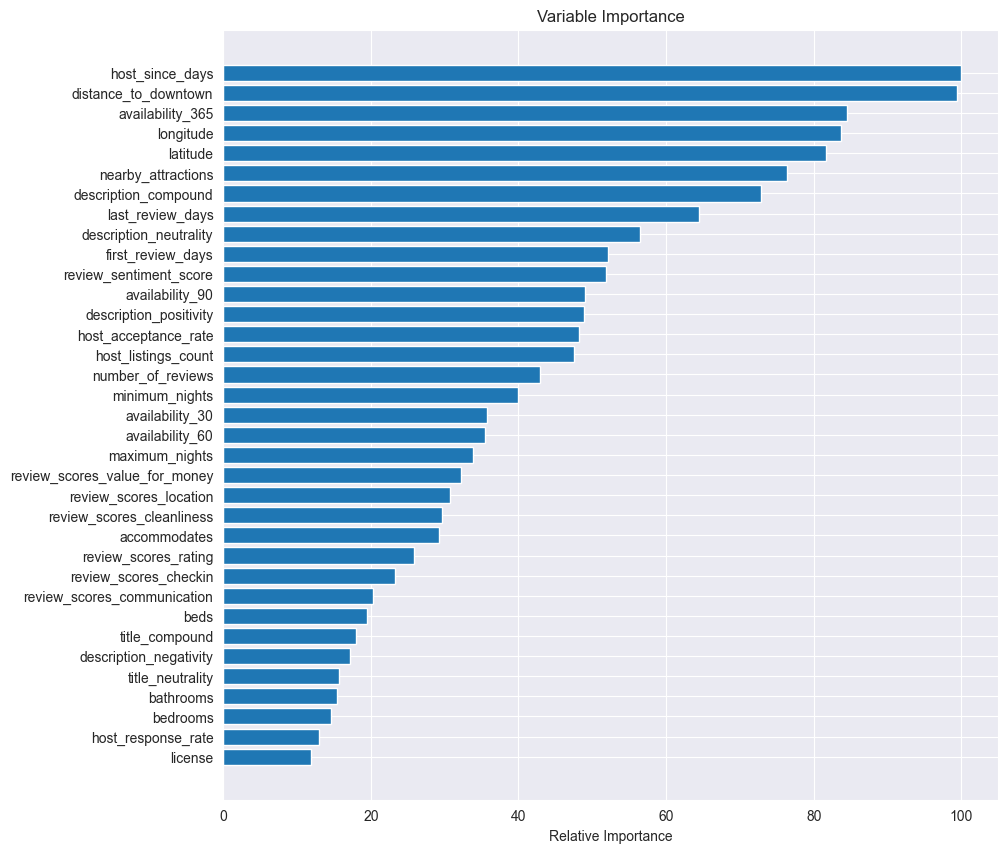

In [50]:
# Plot feature importance
top = 35
feature_importance = final_model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [57]:
X_train.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,grill_amenity,Mosquito net_amenity,title_compound,title_negativity,title_neutrality,title_positivity,description_compound,description_negativity,description_neutrality,description_positivity
45298,100.0,100.0,False,True,True,48.564880,-123.452100,2,1.0,1.0,...,False,False,0.0000,0.0,1.000,0.000,0.9042,0.0,0.865,0.135
15387,100.0,98.0,False,True,True,46.816720,-71.220840,4,1.0,2.0,...,False,False,0.0000,0.0,1.000,0.000,0.7569,0.0,0.919,0.081
27145,100.0,100.0,False,True,True,43.815680,-79.311180,2,1.5,1.0,...,False,False,0.0000,0.0,1.000,0.000,0.9684,0.0,0.622,0.378
4932,100.0,100.0,True,True,True,45.534105,-73.595753,6,1.0,3.0,...,False,False,0.0000,0.0,1.000,0.000,0.8658,0.0,0.863,0.137
280,100.0,96.0,True,True,True,45.555629,-73.588936,6,1.0,2.0,...,False,False,0.2732,0.0,0.769,0.231,0.9634,0.0,0.738,0.262


Drop additional useless features

iter 3

In [63]:
useless_features = [
    'latitude', 'longitude', 'maximum_nights', 'availability_60', 'availability_60', 'availability_90', 'availability_365', 'description_positivity', 'description_neutrality', 'description_negativity', 'title_positivity', 'title_neutrality', 'title_negativity'
]

In [64]:
# Drop features with 0 importance from X_train and X_valid
X_train_reduced = X_train.drop(columns=useless_features)
X_test_reduced = X_test.drop(columns=useless_features)

In [65]:
X_train_reduced.shape, X_test_reduced.shape

((33288, 194), (8284, 194))

In [66]:
X_train.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,grill_amenity,Mosquito net_amenity,title_compound,title_negativity,title_neutrality,title_positivity,description_compound,description_negativity,description_neutrality,description_positivity
45298,100.0,100.0,False,True,True,48.564880,-123.452100,2,1.0,1.0,...,False,False,0.0000,0.0,1.000,0.000,0.9042,0.0,0.865,0.135
15387,100.0,98.0,False,True,True,46.816720,-71.220840,4,1.0,2.0,...,False,False,0.0000,0.0,1.000,0.000,0.7569,0.0,0.919,0.081
27145,100.0,100.0,False,True,True,43.815680,-79.311180,2,1.5,1.0,...,False,False,0.0000,0.0,1.000,0.000,0.9684,0.0,0.622,0.378
4932,100.0,100.0,True,True,True,45.534105,-73.595753,6,1.0,3.0,...,False,False,0.0000,0.0,1.000,0.000,0.8658,0.0,0.863,0.137
280,100.0,96.0,True,True,True,45.555629,-73.588936,6,1.0,2.0,...,False,False,0.2732,0.0,0.769,0.231,0.9634,0.0,0.738,0.262


In [67]:
final_model_lgbm.fit(X_train_reduced, y_train)
y_pred_gbm = final_model_lgbm.predict(X_test_reduced)
ytrai_gbm = final_model_lgbm.predict(X_train_reduced)

# Evaluate Light GBM
lgbmr2 = r2_score(y_test, y_pred_gbm)
lgbmmse = mean_squared_error(y_test, y_pred_gbm)

# Evaluate Light GBM
lgbmr2t = r2_score(y_train, ytrai_gbm)
lgbmmset = mean_squared_error(y_train, ytrai_gbm)

# Calculating and printing the evaluation metrices values
print(f'Light GBM Fitting:')
print(f'R2 Score: {lgbmr2}')
print(f'MSE: {lgbmmse}')

print (lgbmr2t)
print (lgbmmset)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Light GBM Fitting:
R2 Score: 0.7529242506960783
MSE: 0.1224306072811495
0.9697781642787171
0.014979189212979973


In [ ]:
# # Reduce overfitting
# model_lgbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=3000, num_leaves=100, min_data_in_leaf=1000, verbose=0, max_depth=10, random_state=42)
# 
# model_lgbm.fit(X_train_scaled, y_train)
# y_pred_gbm2 = model_lgbm.predict(X_test_scaled)
# ytrai_gbm2 = model_lgbm.predict(X_train_scaled)
# 
# # Evaluate Light GBM
# lgbm2r2 = r2_score(y_test, y_pred_gbm2)
# lgbm2mse = mean_squared_error(y_test, y_pred_gbm2)
# 
# # Evaluate Light GBM
# lgbm2r2t = r2_score(y_train, ytrai_gbm2)
# lgbm2mset = mean_squared_error(y_train, ytrai_gbm2)
# 
# # Calculating and printing the evaluation metrices values
# print(f'Light GBM Test Fitting:')
# print(f'R2 Score: {lgbm2r2}')
# print(f'MSE: {lgbm2mse}')
# 
# print(f'Light GBM Traing Fitting:')
# print(f'R2 Score: {lgbm2r2t}')
# print(f'MSE: {lgbm2mset}')